# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
!unzip processed_celeba_small.zip

Archive:  processed_celeba_small.zip
replace processed_celeba_small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    # resize and normalize the images
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
    
    # get training data and test directories
    image_path = './' + data_dir
    
    # define datasets using ImageFolder
    image_dataset = datasets.ImageFolder(image_path, transform=transform)
    
    # create and return dataloader
    dataloader = DataLoader(dataset=image_dataset, batch_size=batch_size, shuffle=True)
    
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

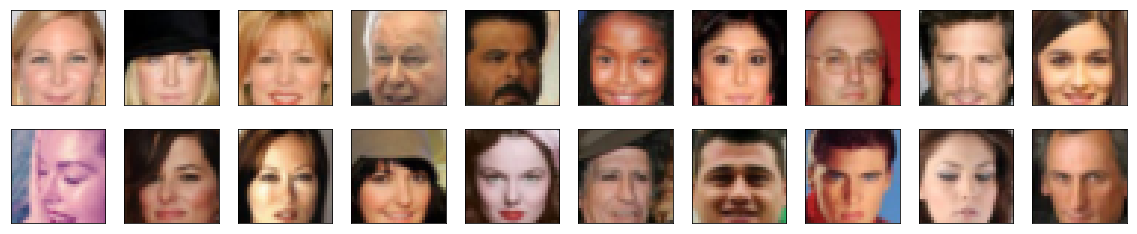

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min_rng, max_rng = feature_range
    x = x * (max_rng - min_rng) + min_rng
    return x


In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8431)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
def conv_helper(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    Creates a convolutional layer, with optional batch normalization
    """
    
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                           kernel_size=kernel_size, stride=stride,
                           padding=padding, bias=False)
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # 32x32
        self.conv1 = conv_helper(3, conv_dim, 4, batch_norm=False)
        # 16x16
        self.conv2 = conv_helper(conv_dim, conv_dim*2, 4)
        # 8x8
        self.conv3 = conv_helper(conv_dim*2, conv_dim*4, 4)
        # 4x4
    
        self.fc = nn.Linear(conv_dim*4*4*4, 1) # True or Fake

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = x.view(-1, self.conv_dim*4*4*4) # 1 output node
        x = self.fc(x)
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
def deconv_helper(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    t_conv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels,
                                kernel_size=kernel_size, stride=stride,
                                padding=padding, bias=False)
    layers.append(t_conv)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)

In [12]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        self.conv_dim = conv_dim
        
        # complete init function
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        #4x4
        self.t_conv1 = deconv_helper(conv_dim*4, conv_dim*2, 4)
        #8x8
        self.t_conv2 = deconv_helper(conv_dim*2, conv_dim, 4)
        #16x16
        self.t_conv3 = deconv_helper(conv_dim, 3, 4, batch_norm=False)
        #32x32
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*4, 4, 4)
        
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.tanh(self.t_conv3(x))
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [13]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    init_gain = 0.02
    
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, 0.0, init_gain)
        
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)
            
    # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
#     elif classname.find('BatchNorm2d') != -1:
#         nn.init.normal_(m.weight.data, 1.0, init_gain)
#         nn.init.constant_(m.bias.data, 0.0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [15]:
# Define model hyperparams
d_conv_dim = 128
g_conv_dim = 128
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=8192, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1,

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [17]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size) # real labels = 1
    
    # move labels to GPU if available
    if train_on_gpu:
        labels = labels.cuda()
    
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    
    # move labels to GPU if available
    if train_on_gpu:
        labels = labels.cuda()
        
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [18]:
import torch.optim as optim

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [19]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # ===============================================
            #            TRAIN THE DISCRIMINATOR
            # ===============================================
            
            d_optimizer.zero_grad()
            
            # 1. Train the discriminator on real and fake images
            if train_on_gpu:
                real_images = real_images.cuda()
            
            d_real_outp = D(real_images)                            # discriminate real images
            d_real_loss = real_loss(d_real_outp)                    # calculate loss of discriminated real images
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size)) # randomly generate the input z vector
            z = torch.from_numpy(z).float()                         # convert z from numpy to tensor            
            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z)                                      # generate fake images
            
            d_fake_outp = D(fake_images)                            # discriminate fake images
            d_fake_loss = fake_loss(d_fake_outp)                    # calculate loss of discriminated fake images
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
           
            # ===============================================
            #            TRAIN THE GENERATOR
            # ===============================================

            g_optimizer.zero_grad()
            
            # 2. Train the generator with an adversarial loss
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size)) # randomly generate the input z vector
            z = torch.from_numpy(z).float()                         # convert z from numpy to tensor
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)                                      # generate fake images
            
            d_fake_outp = D(fake_images)                            # discriminate fake images
            g_loss = real_loss(d_fake_outp)                         # calculate loss of discriminated fake images
            
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [20]:
# set number of epochs 
n_epochs = 30


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   30] | d_loss: 1.4272 | g_loss: 1.4281
Epoch [    1/   30] | d_loss: 0.0729 | g_loss: 6.2270
Epoch [    1/   30] | d_loss: 0.2814 | g_loss: 3.8260
Epoch [    1/   30] | d_loss: 0.9878 | g_loss: 5.7439
Epoch [    1/   30] | d_loss: 0.6546 | g_loss: 4.5664
Epoch [    1/   30] | d_loss: 0.6468 | g_loss: 3.1668
Epoch [    1/   30] | d_loss: 0.3497 | g_loss: 1.1200
Epoch [    1/   30] | d_loss: 0.8800 | g_loss: 1.3060
Epoch [    1/   30] | d_loss: 0.9564 | g_loss: 2.6692
Epoch [    1/   30] | d_loss: 1.0585 | g_loss: 3.5561
Epoch [    1/   30] | d_loss: 0.9295 | g_loss: 1.4125
Epoch [    1/   30] | d_loss: 1.0157 | g_loss: 2.3429
Epoch [    1/   30] | d_loss: 1.1806 | g_loss: 1.3102
Epoch [    1/   30] | d_loss: 0.9949 | g_loss: 1.8692
Epoch [    1/   30] | d_loss: 0.9962 | g_loss: 2.8358
Epoch [    1/   30] | d_loss: 0.9931 | g_loss: 1.6603
Epoch [    1/   30] | d_loss: 1.4776 | g_loss: 3.5078
Epoch [    1/   30] | d_loss: 0.9633 | g_loss: 1.4327
Epoch [    1/   30] | d_loss

Epoch [    3/   30] | d_loss: 1.1526 | g_loss: 1.3213
Epoch [    3/   30] | d_loss: 0.8791 | g_loss: 1.2990
Epoch [    3/   30] | d_loss: 1.4854 | g_loss: 2.0056
Epoch [    3/   30] | d_loss: 0.8821 | g_loss: 2.2874
Epoch [    3/   30] | d_loss: 1.1792 | g_loss: 1.8004
Epoch [    3/   30] | d_loss: 0.8284 | g_loss: 1.5059
Epoch [    3/   30] | d_loss: 1.0567 | g_loss: 1.5542
Epoch [    3/   30] | d_loss: 1.1955 | g_loss: 2.0099
Epoch [    3/   30] | d_loss: 1.2408 | g_loss: 1.3050
Epoch [    3/   30] | d_loss: 1.2269 | g_loss: 1.2258
Epoch [    3/   30] | d_loss: 1.0968 | g_loss: 1.2686
Epoch [    3/   30] | d_loss: 0.7043 | g_loss: 0.9164
Epoch [    3/   30] | d_loss: 0.8842 | g_loss: 1.3974
Epoch [    3/   30] | d_loss: 0.9140 | g_loss: 1.0259
Epoch [    3/   30] | d_loss: 0.9695 | g_loss: 0.9810
Epoch [    3/   30] | d_loss: 1.4378 | g_loss: 1.5996
Epoch [    3/   30] | d_loss: 1.0580 | g_loss: 1.6246
Epoch [    3/   30] | d_loss: 1.4105 | g_loss: 1.4926
Epoch [    3/   30] | d_loss

Epoch [    6/   30] | d_loss: 0.9773 | g_loss: 1.2585
Epoch [    6/   30] | d_loss: 1.2925 | g_loss: 1.3999
Epoch [    6/   30] | d_loss: 0.8034 | g_loss: 1.0058
Epoch [    6/   30] | d_loss: 0.8045 | g_loss: 2.2145
Epoch [    6/   30] | d_loss: 0.6811 | g_loss: 1.6907
Epoch [    6/   30] | d_loss: 0.7388 | g_loss: 1.5985
Epoch [    6/   30] | d_loss: 0.7192 | g_loss: 1.2078
Epoch [    6/   30] | d_loss: 0.6909 | g_loss: 1.7674
Epoch [    6/   30] | d_loss: 1.0141 | g_loss: 2.1704
Epoch [    6/   30] | d_loss: 0.8530 | g_loss: 1.8286
Epoch [    6/   30] | d_loss: 0.7083 | g_loss: 0.7482
Epoch [    6/   30] | d_loss: 0.6704 | g_loss: 2.1801
Epoch [    6/   30] | d_loss: 0.8681 | g_loss: 1.0047
Epoch [    6/   30] | d_loss: 0.8334 | g_loss: 1.4663
Epoch [    6/   30] | d_loss: 1.0048 | g_loss: 2.5740
Epoch [    6/   30] | d_loss: 0.7561 | g_loss: 1.4194
Epoch [    6/   30] | d_loss: 0.6060 | g_loss: 1.2602
Epoch [    6/   30] | d_loss: 0.8785 | g_loss: 1.8538
Epoch [    6/   30] | d_loss

Epoch [    9/   30] | d_loss: 0.6263 | g_loss: 2.6006
Epoch [    9/   30] | d_loss: 0.3757 | g_loss: 1.6283
Epoch [    9/   30] | d_loss: 0.5695 | g_loss: 3.1745
Epoch [    9/   30] | d_loss: 0.7521 | g_loss: 1.4266
Epoch [    9/   30] | d_loss: 0.6866 | g_loss: 1.4425
Epoch [    9/   30] | d_loss: 1.7009 | g_loss: 4.4901
Epoch [    9/   30] | d_loss: 0.5458 | g_loss: 2.0920
Epoch [    9/   30] | d_loss: 0.4446 | g_loss: 1.8581
Epoch [    9/   30] | d_loss: 0.5236 | g_loss: 2.6904
Epoch [    9/   30] | d_loss: 0.4590 | g_loss: 2.6582
Epoch [    9/   30] | d_loss: 0.6795 | g_loss: 3.0028
Epoch [    9/   30] | d_loss: 1.0511 | g_loss: 3.6865
Epoch [    9/   30] | d_loss: 0.5131 | g_loss: 1.1780
Epoch [    9/   30] | d_loss: 0.7436 | g_loss: 3.3812
Epoch [    9/   30] | d_loss: 0.9522 | g_loss: 2.5678
Epoch [    9/   30] | d_loss: 1.2959 | g_loss: 6.5838
Epoch [    9/   30] | d_loss: 0.7115 | g_loss: 1.0276
Epoch [    9/   30] | d_loss: 0.5204 | g_loss: 2.3118
Epoch [    9/   30] | d_loss

Epoch [   11/   30] | d_loss: 0.4628 | g_loss: 2.8907
Epoch [   11/   30] | d_loss: 0.1704 | g_loss: 3.2609
Epoch [   11/   30] | d_loss: 0.1944 | g_loss: 2.5569
Epoch [   11/   30] | d_loss: 0.3324 | g_loss: 2.8679
Epoch [   11/   30] | d_loss: 0.4711 | g_loss: 3.9236
Epoch [   11/   30] | d_loss: 0.3407 | g_loss: 2.3750
Epoch [   11/   30] | d_loss: 0.2665 | g_loss: 2.5001
Epoch [   11/   30] | d_loss: 0.3628 | g_loss: 2.5079
Epoch [   11/   30] | d_loss: 0.4425 | g_loss: 2.1227
Epoch [   11/   30] | d_loss: 2.0072 | g_loss: 0.1986
Epoch [   11/   30] | d_loss: 0.3722 | g_loss: 2.8192
Epoch [   11/   30] | d_loss: 0.3874 | g_loss: 2.2875
Epoch [   11/   30] | d_loss: 0.2855 | g_loss: 1.7232
Epoch [   11/   30] | d_loss: 0.6167 | g_loss: 3.2706
Epoch [   11/   30] | d_loss: 0.1402 | g_loss: 3.3485
Epoch [   11/   30] | d_loss: 0.2326 | g_loss: 2.7482
Epoch [   11/   30] | d_loss: 0.2368 | g_loss: 3.3544
Epoch [   11/   30] | d_loss: 0.3123 | g_loss: 2.2797
Epoch [   11/   30] | d_loss

Epoch [   14/   30] | d_loss: 0.2139 | g_loss: 3.0479
Epoch [   14/   30] | d_loss: 0.1698 | g_loss: 2.8738
Epoch [   14/   30] | d_loss: 0.3117 | g_loss: 3.0488
Epoch [   14/   30] | d_loss: 0.3318 | g_loss: 3.3025
Epoch [   14/   30] | d_loss: 0.1626 | g_loss: 2.8146
Epoch [   14/   30] | d_loss: 0.1765 | g_loss: 4.3279
Epoch [   14/   30] | d_loss: 0.3557 | g_loss: 2.5803
Epoch [   14/   30] | d_loss: 0.5145 | g_loss: 2.7249
Epoch [   14/   30] | d_loss: 0.1326 | g_loss: 3.9950
Epoch [   14/   30] | d_loss: 0.4472 | g_loss: 3.4494
Epoch [   14/   30] | d_loss: 0.1834 | g_loss: 2.6264
Epoch [   14/   30] | d_loss: 0.2221 | g_loss: 4.1284
Epoch [   14/   30] | d_loss: 0.1803 | g_loss: 5.6081
Epoch [   14/   30] | d_loss: 0.0943 | g_loss: 5.0507
Epoch [   14/   30] | d_loss: 0.2257 | g_loss: 3.8757
Epoch [   14/   30] | d_loss: 0.9086 | g_loss: 2.7447
Epoch [   14/   30] | d_loss: 0.2796 | g_loss: 3.9173
Epoch [   14/   30] | d_loss: 0.2460 | g_loss: 4.5479
Epoch [   14/   30] | d_loss

Epoch [   17/   30] | d_loss: 0.1994 | g_loss: 3.8809
Epoch [   17/   30] | d_loss: 0.1141 | g_loss: 4.3038
Epoch [   17/   30] | d_loss: 0.6889 | g_loss: 0.7136
Epoch [   17/   30] | d_loss: 0.1386 | g_loss: 3.9849
Epoch [   17/   30] | d_loss: 0.1010 | g_loss: 4.0420
Epoch [   17/   30] | d_loss: 0.0779 | g_loss: 5.0547
Epoch [   17/   30] | d_loss: 0.1180 | g_loss: 3.7274
Epoch [   17/   30] | d_loss: 0.0663 | g_loss: 4.6570
Epoch [   17/   30] | d_loss: 0.0841 | g_loss: 5.6161
Epoch [   17/   30] | d_loss: 0.2309 | g_loss: 5.3516
Epoch [   17/   30] | d_loss: 0.2169 | g_loss: 4.5872
Epoch [   17/   30] | d_loss: 1.7764 | g_loss: 6.0857
Epoch [   17/   30] | d_loss: 0.4815 | g_loss: 6.8311
Epoch [   17/   30] | d_loss: 0.1786 | g_loss: 2.0299
Epoch [   17/   30] | d_loss: 0.4010 | g_loss: 4.9451
Epoch [   17/   30] | d_loss: 0.3283 | g_loss: 5.0849
Epoch [   17/   30] | d_loss: 0.2786 | g_loss: 3.8378
Epoch [   17/   30] | d_loss: 0.0782 | g_loss: 6.3261
Epoch [   17/   30] | d_loss

Epoch [   19/   30] | d_loss: 0.1045 | g_loss: 5.0721
Epoch [   19/   30] | d_loss: 0.1871 | g_loss: 3.8795
Epoch [   19/   30] | d_loss: 0.1833 | g_loss: 3.5135
Epoch [   19/   30] | d_loss: 0.1422 | g_loss: 5.8759
Epoch [   19/   30] | d_loss: 0.0736 | g_loss: 5.3538
Epoch [   19/   30] | d_loss: 0.0954 | g_loss: 5.1717
Epoch [   19/   30] | d_loss: 0.1111 | g_loss: 3.7532
Epoch [   19/   30] | d_loss: 0.0428 | g_loss: 4.0086
Epoch [   19/   30] | d_loss: 0.0759 | g_loss: 4.4975
Epoch [   19/   30] | d_loss: 0.1293 | g_loss: 2.4252
Epoch [   19/   30] | d_loss: 0.2296 | g_loss: 4.4002
Epoch [   19/   30] | d_loss: 2.5958 | g_loss: 1.0070
Epoch [   19/   30] | d_loss: 0.7282 | g_loss: 2.8575
Epoch [   19/   30] | d_loss: 0.1385 | g_loss: 4.8971
Epoch [   19/   30] | d_loss: 0.0427 | g_loss: 3.8954
Epoch [   19/   30] | d_loss: 0.2452 | g_loss: 3.7295
Epoch [   19/   30] | d_loss: 0.6938 | g_loss: 3.0157
Epoch [   19/   30] | d_loss: 0.0831 | g_loss: 4.5315
Epoch [   19/   30] | d_loss

Epoch [   22/   30] | d_loss: 2.7373 | g_loss: 0.3440
Epoch [   22/   30] | d_loss: 0.3139 | g_loss: 2.2783
Epoch [   22/   30] | d_loss: 0.1263 | g_loss: 3.0141
Epoch [   22/   30] | d_loss: 0.2550 | g_loss: 4.8230
Epoch [   22/   30] | d_loss: 0.0422 | g_loss: 4.0006
Epoch [   22/   30] | d_loss: 0.2556 | g_loss: 4.9448
Epoch [   22/   30] | d_loss: 0.0578 | g_loss: 3.6420
Epoch [   22/   30] | d_loss: 0.0554 | g_loss: 5.1647
Epoch [   22/   30] | d_loss: 0.1255 | g_loss: 3.0384
Epoch [   22/   30] | d_loss: 0.6318 | g_loss: 1.7900
Epoch [   22/   30] | d_loss: 0.0665 | g_loss: 6.2700
Epoch [   22/   30] | d_loss: 0.0901 | g_loss: 4.6730
Epoch [   22/   30] | d_loss: 0.2908 | g_loss: 5.0087
Epoch [   22/   30] | d_loss: 0.0599 | g_loss: 4.1245
Epoch [   22/   30] | d_loss: 2.2760 | g_loss: 1.1755
Epoch [   22/   30] | d_loss: 0.4461 | g_loss: 3.2828
Epoch [   22/   30] | d_loss: 0.2281 | g_loss: 3.9995
Epoch [   22/   30] | d_loss: 0.0601 | g_loss: 4.5138
Epoch [   22/   30] | d_loss

Epoch [   25/   30] | d_loss: 0.0539 | g_loss: 4.5629
Epoch [   25/   30] | d_loss: 0.0684 | g_loss: 4.5215
Epoch [   25/   30] | d_loss: 0.0542 | g_loss: 5.9698
Epoch [   25/   30] | d_loss: 0.0657 | g_loss: 5.7624
Epoch [   25/   30] | d_loss: 0.0283 | g_loss: 5.3323
Epoch [   25/   30] | d_loss: 0.0819 | g_loss: 3.7241
Epoch [   25/   30] | d_loss: 1.7644 | g_loss: 10.1903
Epoch [   25/   30] | d_loss: 0.3972 | g_loss: 1.7490
Epoch [   25/   30] | d_loss: 0.1312 | g_loss: 4.1465
Epoch [   25/   30] | d_loss: 0.1607 | g_loss: 2.3012
Epoch [   25/   30] | d_loss: 0.0557 | g_loss: 4.8820
Epoch [   25/   30] | d_loss: 0.0501 | g_loss: 5.2260
Epoch [   25/   30] | d_loss: 0.0242 | g_loss: 4.5550
Epoch [   25/   30] | d_loss: 0.1113 | g_loss: 5.0243
Epoch [   25/   30] | d_loss: 0.0626 | g_loss: 5.7323
Epoch [   25/   30] | d_loss: 0.0533 | g_loss: 5.4440
Epoch [   25/   30] | d_loss: 0.0282 | g_loss: 4.4232
Epoch [   25/   30] | d_loss: 0.0469 | g_loss: 4.1304
Epoch [   25/   30] | d_los

Epoch [   27/   30] | d_loss: 0.7209 | g_loss: 1.5790
Epoch [   27/   30] | d_loss: 0.2442 | g_loss: 4.1975
Epoch [   27/   30] | d_loss: 0.1222 | g_loss: 3.9560
Epoch [   27/   30] | d_loss: 0.1051 | g_loss: 6.4115
Epoch [   27/   30] | d_loss: 0.1585 | g_loss: 5.1281
Epoch [   27/   30] | d_loss: 0.1458 | g_loss: 4.6499
Epoch [   27/   30] | d_loss: 0.2262 | g_loss: 3.2997
Epoch [   27/   30] | d_loss: 1.2649 | g_loss: 4.4454
Epoch [   27/   30] | d_loss: 0.0452 | g_loss: 5.0042
Epoch [   27/   30] | d_loss: 0.0498 | g_loss: 5.7520
Epoch [   27/   30] | d_loss: 0.0773 | g_loss: 3.6021
Epoch [   27/   30] | d_loss: 1.2570 | g_loss: 2.0352
Epoch [   27/   30] | d_loss: 0.0344 | g_loss: 6.0389
Epoch [   27/   30] | d_loss: 0.1287 | g_loss: 6.1911
Epoch [   27/   30] | d_loss: 0.0489 | g_loss: 3.8118
Epoch [   27/   30] | d_loss: 0.2489 | g_loss: 3.8957
Epoch [   27/   30] | d_loss: 0.1617 | g_loss: 5.0938
Epoch [   27/   30] | d_loss: 0.0865 | g_loss: 5.3533
Epoch [   27/   30] | d_loss

Epoch [   30/   30] | d_loss: 0.0677 | g_loss: 5.2822
Epoch [   30/   30] | d_loss: 0.0293 | g_loss: 6.8287
Epoch [   30/   30] | d_loss: 0.0310 | g_loss: 4.4860
Epoch [   30/   30] | d_loss: 0.0964 | g_loss: 5.5203
Epoch [   30/   30] | d_loss: 0.0214 | g_loss: 4.7964
Epoch [   30/   30] | d_loss: 0.7190 | g_loss: 1.7011
Epoch [   30/   30] | d_loss: 0.2864 | g_loss: 5.5127
Epoch [   30/   30] | d_loss: 0.1049 | g_loss: 5.1323
Epoch [   30/   30] | d_loss: 0.1862 | g_loss: 3.2610
Epoch [   30/   30] | d_loss: 0.1506 | g_loss: 4.8920
Epoch [   30/   30] | d_loss: 0.1499 | g_loss: 5.1214
Epoch [   30/   30] | d_loss: 0.1041 | g_loss: 4.0166
Epoch [   30/   30] | d_loss: 0.0882 | g_loss: 5.9423
Epoch [   30/   30] | d_loss: 0.1875 | g_loss: 4.9641
Epoch [   30/   30] | d_loss: 0.0161 | g_loss: 6.4189
Epoch [   30/   30] | d_loss: 0.0491 | g_loss: 2.6966
Epoch [   30/   30] | d_loss: 0.0482 | g_loss: 3.7947
Epoch [   30/   30] | d_loss: 0.0665 | g_loss: 6.8031
Epoch [   30/   30] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

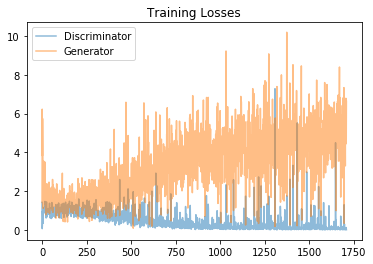

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [22]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [23]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

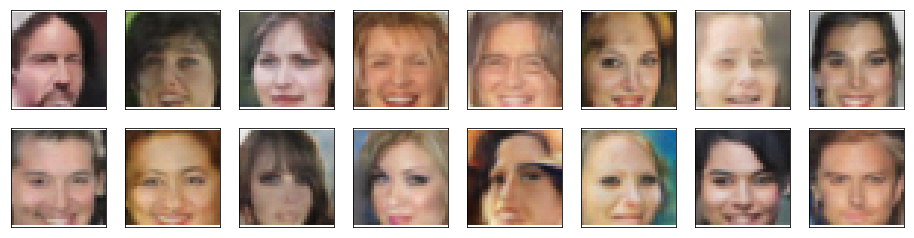

In [24]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)
1. The dataset is biased; it is made of "celebrity" faces that are mostly white

The dataset could be extended to include celebrity faces which are black as well. We need to insure that the number of black faces are almost or nearly equal to the white faces.

2. Model size; larger models have the opportunity to learn more features in a data feature space

In convolutional neural networks, the deeper the network, the more it learns more feature and perform better. Since the dataset used for this project is more complex compared the to handwritten digits from MNIST dataset, so defining a deeper architecture could ensure better performance in face generation.

3. Optimization strategy; optimizers and number of epochs affect your final result

Adam optimizer is the favourite for the DCGAN training. Because it combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems (ex: noisy images).

Also, the more the number of epochs/iterations used for training, the more the model is accurate.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.